# Golf R-value Analysis using Generalized R Method


## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


## Load Golf Data


In [5]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Load the golf CSV file - adjust path as needed
golf_raw = pd.read_csv('adjustpathhere/PGAresults.csv')

# Display all columns
pd.set_option('display.max_columns', None)

golf_raw.head()

Mounted at /content/drive


,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,streak_SDP,n_rounds,made_cut,pos,finish_DKP,finish_FDP,finish_SDP,total_DKP,total_FDP,total_SDP,player,Unnamed: 2,Unnamed: 3,Unnamed: 4,tournament name,course,date,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,3,4,1,32.0,2,1,0,65.0,59.7,59,Abraham Ancer,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,3,4,1,18.0,5,4,2,85.5,78.5,66,Adam Hadwin,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,0,2,0,NaN,0,0,0,21.5,17.4,27,Anirban Lahiri,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,0,2,0,NaN,0,0,0,20.5,14.0,17,Adam Long,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,0,2,0,NaN,0,0,0,23.5,19.3,23,Alexander Noren,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


## Data Preprocessing

In [6]:
# Create clean dataset
golf_clean = golf_raw.copy()

# Ensure we have necessary columns
required_cols = ['player', 'season', 'tournament name', 'sg_total', 'made_cut']
missing_cols = [col for col in required_cols if col not in golf_clean.columns]
if missing_cols:
    print(f"⚠️ Missing columns: {missing_cols}")
    print("Please check column names!")

# Handle missed cuts: assign sg_total = 0 (or a penalty value)
# For missed cuts, sg_total might be NaN - we'll set it to 0
golf_clean['sg_total_adjusted'] = golf_clean.apply(
    lambda row: row['sg_total'] if row['made_cut'] == 1 else 0.0,
    axis=1
)

# Convert date to datetime if needed
if 'date' in golf_clean.columns:
    golf_clean['date'] = pd.to_datetime(golf_clean['date'], errors='coerce')

# Remove any rows with missing critical data
before_len = len(golf_clean)
golf_clean = golf_clean.dropna(subset=['player', 'season', 'tournament name'])
after_len = len(golf_clean)

print(golf_clean['sg_total_adjusted'].describe())

# Check made cut rate
made_cut_rate = golf_clean['made_cut'].mean()

count    31576.000000
mean         0.379264
std          1.128803
min        -11.390000
25%          0.000000
50%          0.000000
75%          0.900000
max          8.520000
Name: sg_total_adjusted, dtype: float64


## Organize Data by Season and Player

In [7]:
# Organize by season
data_dict_golf = {}

for season in golf_clean['season'].unique():
    season_data = golf_clean[golf_clean['season'] == season].copy()

    # Sort by date if available
    if 'date' in season_data.columns:
        season_data = season_data.sort_values('date')

    data_dict_golf[str(season)] = season_data

for season in sorted(data_dict_golf.keys()):
    season_df = data_dict_golf[season]
    n_players = season_df['player'].nunique()
    n_tournaments = season_df['tournament name'].nunique()
    avg_tournaments_per_player = len(season_df) / n_players
    print(f"  {season}: {n_players} players, {n_tournaments} tournaments, "
          f"{avg_tournaments_per_player:.1f} avg tournaments/player")

  2015: 278 players, 44 tournaments, 15.0 avg tournaments/player
  2016: 282 players, 41 tournaments, 14.8 avg tournaments/player
  2017: 322 players, 44 tournaments, 14.7 avg tournaments/player
  2018: 343 players, 45 tournaments, 14.5 avg tournaments/player
  2019: 386 players, 44 tournaments, 13.3 avg tournaments/player
  2020: 375 players, 36 tournaments, 11.4 avg tournaments/player
  2021: 421 players, 44 tournaments, 13.5 avg tournaments/player
  2022: 337 players, 32 tournaments, 10.9 avg tournaments/player


## Helper Functions for Golf

In [8]:
def get_player_tournaments(df: pd.DataFrame, player: str) -> pd.DataFrame:
    """
    Get all tournaments for a specific player in a season.
    Similar to _team_rows but for individual player.
    """
    player_data = df[df['player'] == player].copy()

    # Sort by date if available, otherwise by tournament name
    if 'date' in player_data.columns:
        player_data = player_data.sort_values('date')
    else:
        player_data = player_data.sort_values('tournament name')

    return player_data


## Stratified Splitting for Golf


In [9]:
def stratified_split_golf(player_tournaments, rng, stratify_by_purse=False):
    """
    Split player's tournaments into two folds (A, B).
    Optionally stratify by purse (field strength proxy).
    """
    tournaments = player_tournaments.copy()

    # If we have purse data and want to stratify
    if stratify_by_purse and 'purse' in tournaments.columns:
        # Bin tournaments by purse (field strength proxy)
        try:
            bins = pd.qcut(tournaments['purse'],
                          q=min(3, len(tournaments)),
                          duplicates='drop')
            tournaments['strength_bin'] = bins

            A_idx, B_idx = [], []
            for _, g in tournaments.groupby('strength_bin'):
                idxs = g.index.tolist()
                rng.shuffle(idxs)
                half = len(idxs) // 2
                A_idx.extend(idxs[:half])
                B_idx.extend(idxs[half:])
        except:
            # If stratification fails, fall back to random
            stratify_by_purse = False

    # Simple random split (no stratification)
    if not stratify_by_purse:
        idxs = tournaments.index.tolist()
        rng.shuffle(idxs)
        half = len(idxs) // 2
        A_idx = idxs[:half]
        B_idx = idxs[half:]

    A = tournaments.loc[A_idx]
    B = tournaments.loc[B_idx]

    return A, B


def performance_metric_golf(fold_df):
    """
    Calculate average strokes gained total for a fold.
    Uses sg_total_adjusted which includes missed cuts as 0.
    """
    if len(fold_df) == 0:
        return np.nan

    # Use adjusted sg_total (includes missed cuts as 0)
    avg_sg = fold_df['sg_total_adjusted'].mean()

    return avg_sg


## Generalized R Computation for Golf

In [10]:
def compute_generalized_R_golf(data_dict, K=200, seed=123, min_tournaments=4,
                               stratify_by_purse=False):
    """
    Compute Generalized R-value for golf using strokes gained.

    Parameters:
    - data_dict: dict {season: DataFrame}
    - K: number of random splits per player
    - seed: random seed for reproducibility
    - min_tournaments: minimum tournaments needed for a player to be included
    - stratify_by_purse: whether to stratify splits by tournament purse
    """
    rng = np.random.default_rng(seed)
    rows = []

    for season, df in data_dict.items():
        players = df['player'].unique()
        XY_all = []

        for player in players:
            player_tournaments = get_player_tournaments(df, player)

            # Skip players with too few tournaments
            if len(player_tournaments) < min_tournaments:
                continue

            # K random splits per player
            for k in range(K):
                A, B = stratified_split_golf(player_tournaments, rng, stratify_by_purse)
                x = performance_metric_golf(A)
                y = performance_metric_golf(B)
                if np.isfinite(x) and np.isfinite(y):
                    XY_all.append((x, y))

        if len(XY_all) >= 3:
            X = np.array([u for u, v in XY_all])
            Y = np.array([v for u, v in XY_all])
            S = (X + Y) / np.sqrt(2)
            T = (Y - X) / np.sqrt(2)
            A_var = np.var(S, ddof=0)
            B_var = np.var(T, ddof=0)
            R = 1 - B_var / A_var if A_var > 1e-12 else np.nan

            # Count eligible players
            eligible_players = sum(1 for p in players
                                  if len(get_player_tournaments(df, p)) >= min_tournaments)

            rows.append({
                "sport": "PGA Tour",
                "season": season,
                "metric": "sg_total",
                "players": eligible_players,
                "R": R
            })

    return pd.DataFrame(rows)

## Run the Golf Analysis

In [11]:
# Compute with K=200 splits (as in original paper)
# Start with simple random split (no purse stratification)
gen_r_golf = compute_generalized_R_golf(
    data_dict_golf,
    K=200,
    min_tournaments=4,
    stratify_by_purse=False  # Start simple, can change to True later
)

print(gen_r_golf.to_string(index=False))

   sport season   metric  players        R
PGA Tour   2022 sg_total      243 0.662266
PGA Tour   2021 sg_total      301 0.639034
PGA Tour   2020 sg_total      269 0.547691
PGA Tour   2019 sg_total      276 0.584975
PGA Tour   2018 sg_total      254 0.574947
PGA Tour   2017 sg_total      237 0.540336
PGA Tour   2016 sg_total      217 0.477803
PGA Tour   2015 sg_total      208 0.479799


## Summary Statistics

In [12]:
print(f"Mean R-value: {gen_r_golf['R'].mean():.3f}")
print(f"Median R-value: {gen_r_golf['R'].median():.3f}")
print(f"Std Dev: {gen_r_golf['R'].std():.3f}")
print(f"Min: {gen_r_golf['R'].min():.3f}")
print(f"Max: {gen_r_golf['R'].max():.3f}")
print("\nR-values by season:")
print(gen_r_golf[['season', 'players', 'R']].sort_values('season').to_string(index=False))

Mean R-value: 0.563
Median R-value: 0.561
Std Dev: 0.067
Min: 0.478
Max: 0.662

R-values by season:
season  players        R
  2015      208 0.479799
  2016      217 0.477803
  2017      237 0.540336
  2018      254 0.574947
  2019      276 0.584975
  2020      269 0.547691
  2021      301 0.639034
  2022      243 0.662266


## Visualization Functions

In [13]:
def plot_golf_R_boxplot(df: pd.DataFrame):
    """Create boxplot visualization for PGA Tour R-values"""
    plt.figure(figsize=(10, 4))

    data = [df["R"].dropna().values]

    bp = plt.boxplot(data, vert=False, labels=["PGA Tour"],
                     manage_ticks=True, whis=[5, 95], showmeans=True)

    # Overlay individual season points
    vals = df["R"].dropna().values
    y = np.full_like(vals, 1.0, dtype=float) + (np.random.rand(len(vals)) - 0.5) * 0.06
    plt.plot(vals, y, "o", markersize=6, alpha=0.7)

    plt.xlabel("R (within-season persistence; Generalized R)")
    plt.title("PGA Tour R-value Distribution (Strokes Gained Total)")
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_golf_trend(df: pd.DataFrame):
    """Plot R-value trend over seasons"""
    plt.figure(figsize=(10, 5))

    df_sorted = df.sort_values('season')

    plt.plot(df_sorted['season'].astype(str), df_sorted['R'], 'o-',
             linewidth=2, markersize=8)
    plt.xlabel("Season")
    plt.ylabel("R-value")
    plt.title("PGA Tour R-value Trend Over Time")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


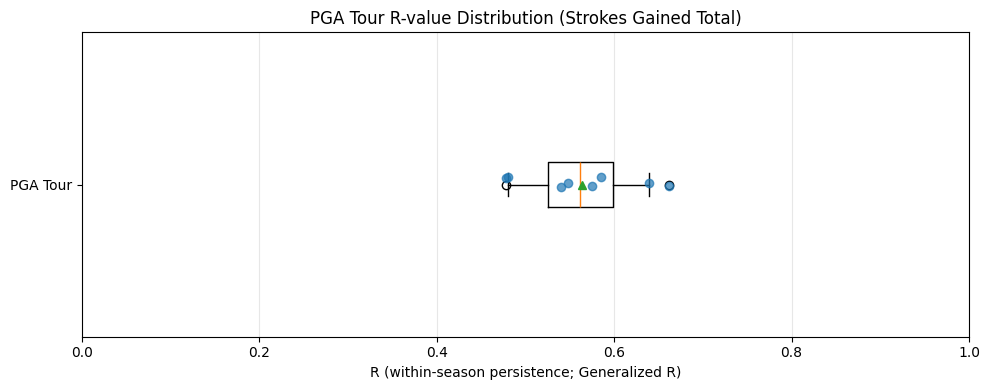

In [14]:
plot_golf_R_boxplot(gen_r_golf)

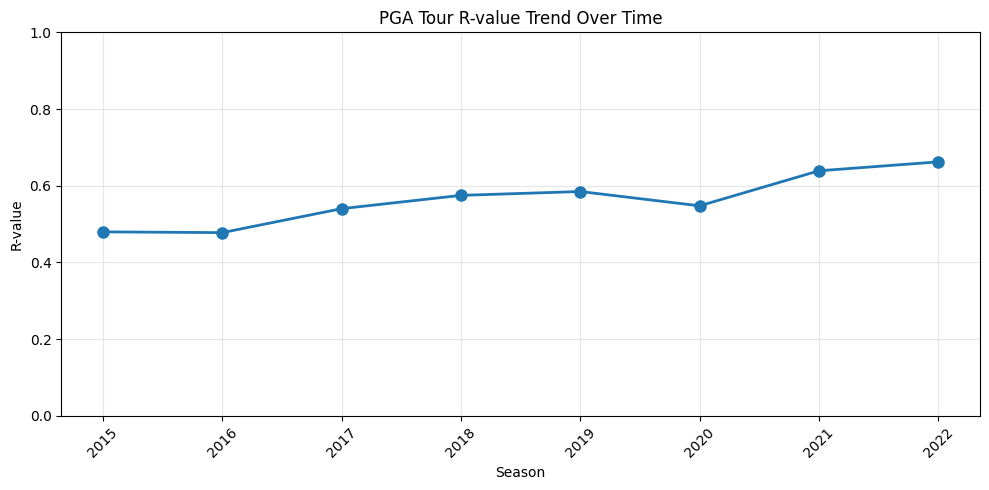

In [15]:
plot_golf_trend(gen_r_golf)

## Save Results

In [16]:
# Save to CSV
output_file = "pga_tour_r_values.csv"
gen_r_golf.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

Results saved to: pga_tour_r_values.csv


## Test with Purse Stratification

In [17]:
if 'purse' in golf_clean.columns:
    gen_r_golf_stratified = compute_generalized_R_golf(
        data_dict_golf,
        K=200,
        min_tournaments=4,
        stratify_by_purse=True
    )

    comparison = pd.merge(
        gen_r_golf[['season', 'R']].rename(columns={'R': 'R_random'}),
        gen_r_golf_stratified[['season', 'R']].rename(columns={'R': 'R_stratified'}),
        on='season'
    )
    comparison['difference'] = comparison['R_stratified'] - comparison['R_random']

    print(f"\nAverage difference: {comparison['difference'].mean():.4f}")
else:
    print("No purse data available for stratification")

Testing with purse stratification...

Comparison: Random vs Purse-Stratified
season  R_random  R_stratified  difference
  2022  0.662266      0.637549   -0.024718
  2021  0.639034      0.621179   -0.017854
  2020  0.547691      0.575367    0.027676
  2019  0.584975      0.586055    0.001080
  2018  0.574947      0.579086    0.004139
  2017  0.540336      0.529503   -0.010832
  2016  0.477803      0.473986   -0.003817
  2015  0.479799      0.458350   -0.021450

Average difference: -0.0057
